# Radial Velocities Fitting

In [2]:
# Double precision with JAX
import jax

jax.config.update("jax_enable_x64", True)

In this tutorial we will learn how to use `jaxoplanet` to compute the radial velocities of a star hosting a single exoplanet, and how to fit this dataset using `numpyro`.

```{note}
This tutorial requires the installation of the following packages:
- [`numpyro`](https://num.pyro.ai)
- [`corner`](https://corner.readthedocs.io)
```

## Model and dataset

Let's first generate our dataset, consisting in the radial velocities of a star orbited by a unique exoplanet. We start by defining the system (see for more details)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import keplerian

truth = dict(mass=0.02, period=3.0)
star = keplerian.Central(mass=1.0, radius=1.0)
true_planet = keplerian.Body(**truth)
system = keplerian.System(star, bodies=[true_planet])

As we left many parameters as default, let's check the parameters of the system

In [4]:
system

System(
  central=Central(
    mass=<Quantity(1.0, 'M_sun')>,
    radius=<Quantity(1.0, 'R_sun')>,
    density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
  ),
  bodies=[
    Body(
      central=Central(
        mass=<Quantity(1.0, 'M_sun')>,
        radius=<Quantity(1.0, 'R_sun')>,
        density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
      ),
      time_ref=<Quantity(-0.75, 'day')>,
      time_transit=<Quantity(0.0, 'day')>,
      period=<Quantity(3.0, 'day')>,
      semimajor=<Quantity(8.811544073109136, 'R_sun')>,
      sin_inclination=<Quantity(1.0, 'dimensionless')>,
      cos_inclination=<Quantity(0.0, 'dimensionless')>,
      impact_param=<Quantity(0.0, 'dimensionless')>,
      mass=<Quantity(0.02, 'M_sun')>,
      radius=None,
      eccentricity=None,
      sin_omega_peri=None,
      cos_omega_peri=None,
      sin_asc_node=None,
      cos_asc_node=None,
      radial_velocity_semiamplitude=None,
      parallax=None
    )
  ],
  _body_stack=BodyStack(...)
)

We can now compute the radial velocities of the star and add some noise to simulate our dataset

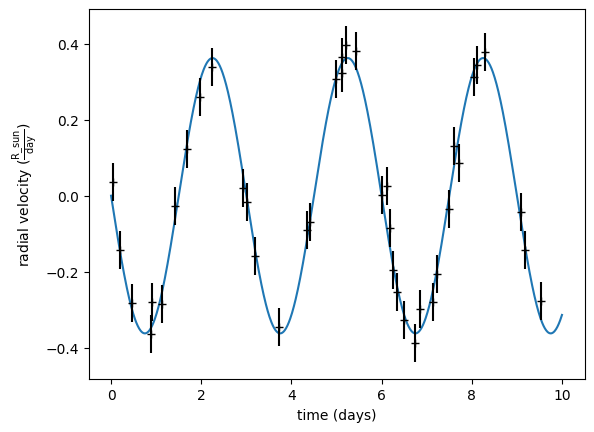

In [10]:
from jaxoplanet.units import unit_registry as ureg

np.random.seed(10)
over_time = np.linspace(0, 10, 1000)
over_rvs = system.radial_velocity(over_time)[0]
time = np.sort(np.random.uniform(0, 10, 40))
rv_obs = system.radial_velocity(time)[0]
rv_err = 0.05 * rv_obs.units
rv_obs += rv_err * np.random.normal(size=len(time))

def plot_data():
    plt.errorbar(time, rv_obs.magnitude, yerr=rv_err.magnitude, fmt="+k")
    plt.xlabel("time (days)")
    plt.ylabel(f"radial velocity (${rv_obs.units:L}$)");

plt.plot(over_time, over_rvs.magnitude)
plot_data()

## Inference

We will infer the value and associated uncertainty of the system orbital parameters using `numpyro`. In order to do that we first define a callable `model` function

In [31]:
import numpyro
import jax.numpy as jnp
from numpyro import distributions as dist, infer


def rv_model(time, params):
    planet = keplerian.Body(mass=params["mass"], period=params["period"])
    system = keplerian.System(central=star, bodies=[planet])
    return system.radial_velocity(time)[0].magnitude


def model(time, y=None):
    mass = numpyro.sample("mass", dist.Uniform(0.01, 0.1))
    period = numpyro.sample("period", dist.Uniform(1.0, 10.0))
    error = numpyro.sample("error", dist.Uniform(0.01, 0.08))
    rv = rv_model(time, {"mass": mass, "period": period})

    # the likelihood function
    numpyro.sample("y", dist.Normal(rv, error), obs=y)

Once the model defined, we will sample the posterior likelihood of the model parameters given the observed radial velocities. As we will need to provide some initial values for these parameters, it is a good idea to check that these values provide a good starting point for the model.

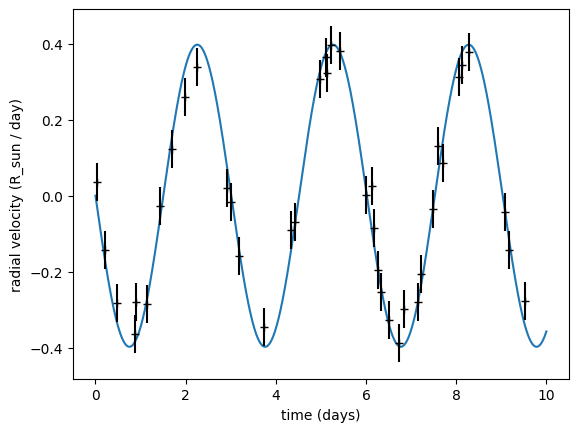

In [33]:
init_values = {"mass": 0.022, "period": 3.01, "error": rv_err.magnitude}
init_model = rv_model(over_time, init_values)

plt.plot(over_time, init_model, "C0")
plot_data()

Starting from this initial guess, we use `numpyro`'s MCMC No-U-Turn Sampler (NUTS) to sample the posterior likelihood of the parameters.

In [34]:
sampler = infer.MCMC(
    infer.NUTS(model, init_strategy=infer.init_to_value(values=init_values)),
    num_warmup=2000,
    num_samples=10000,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(6), time, y=rv_obs.magnitude)

sample: 100%|██████████| 12000/12000 [00:02<00:00, 5040.06it/s, 3 steps of size 8.29e-01. acc. prob=0.88]


We can plot the inferred model with

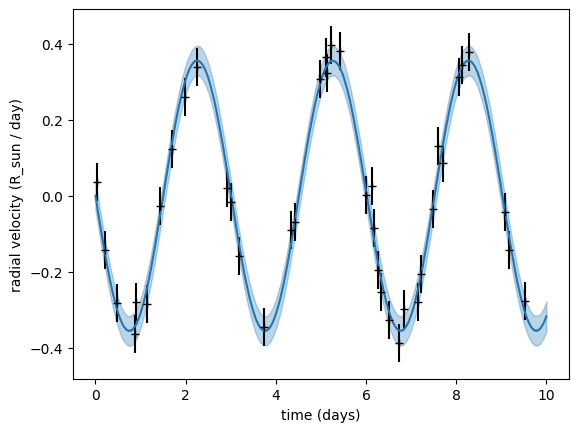

In [36]:
samples = sampler.get_samples()
posterior_rvs = infer.Predictive(model, samples)(jax.random.PRNGKey(0), over_time)["y"]

plot_data()
plt.plot(over_time, posterior_rvs.mean(0), "C0")
plt.fill_between(
    over_time,
    *np.percentile(posterior_rvs, [16, 84], axis=0),
    alpha=0.3,
    color="C0",
)


and check the inferred model parameters in a corner plot

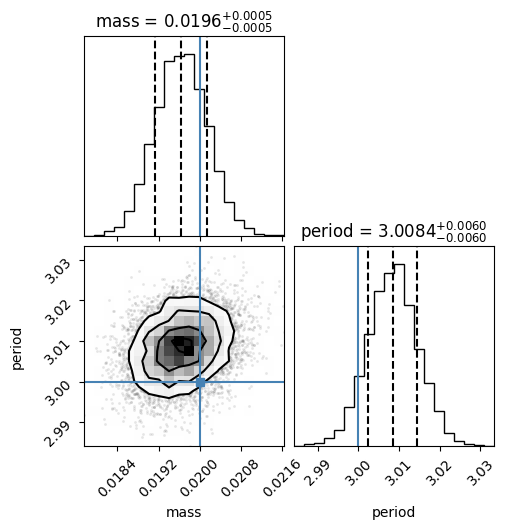

In [37]:
import corner

corner.corner(
    samples,
    var_names=["mass", "period"],
    truths=[truth["mass"], truth["period"]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
);
